### Using GPU

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import tensorflow
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14559139133873104074
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18426733062124747738
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3025456334
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11697840161989380648
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12739012768826896989
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
# Configure the GPU  device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import Libraries

In [5]:
import os
import json
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import konlpy
from konlpy.tag import Okt
from eunjeon import Mecab
from collections import Counter
from tqdm import tqdm
from wordcloud import WordCloud

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [7]:
from gluonnlp.data import BERTSentenceTransform
import gluonnlp as nlp

In [8]:
import sentencepiece as spm
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [9]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [10]:
kobert_tokenizer_path = 'KoBERT/kobert_hf/kobert_tokenizer'
os.listdir(kobert_tokenizer_path)

['kobert_tokenizer.py', '__init__.py', '__pycache__']

In [11]:
from KoBERT.kobert_hf.kobert_tokenizer.kobert_tokenizer import KoBERTTokenizer

In [12]:
from KoBERT.kobert import get_tokenizer
from KoBERT.kobert.pytorch_kobert import get_pytorch_kobert_model

In [13]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer.encode("한국어 모델을 공유합니다.")

[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

In [14]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1', sp_model_kwargs={'nbest_size': -1, 'alpha': 0.6, 'enable_sampling': True})
tokenizer.encode("한국어 모델을 공유합니다.")

[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

In [15]:
import torch
from transformers import BertModel
model = BertModel.from_pretrained('skt/kobert-base-v1')
text = "한국어 모델을 공유합니다."
inputs = tokenizer.batch_encode_plus([text])
out = model(input_ids = torch.tensor(inputs['input_ids']),
              attention_mask = torch.tensor(inputs['attention_mask']))
out.pooler_output.shape

torch.Size([1, 768])

### Check Data: Summary Thesis Data

In [16]:
tl_path = 'SummaryThesisData/Training/LabeledData/'

In [17]:
directory_contents = os.listdir(tl_path)
directory_contents

['TL_thesis',
 '논문요약20231006_0.json',
 '논문요약20231006_1.json',
 '논문요약20231006_2.json',
 '논문요약20231006_3.json']

In [18]:
file_str = tl_path + '논문요약20231006_0.json'

with open(file_str, encoding='utf-8') as f:
    data = json.load(f)
    
data

[{'totalcount': 40000,
  'data': [{'doc_type': '논문',
    'doc_id': 'A201007089365',
    'title': '중세시대의 對句 학습과 문학 교육',
    'date': '2002',
    'reg_no': 'ART000851216',
    'ipc': '인문학',
    'issued_by': '한국문학교육학회',
    'author': '김성룡',
    'summary_entire': [{'orginal_text': '짐작할 수 있는 것처럼, 對句의 영역은 음운, 단어, 어구, 시편의 차원에서 다양하게 이뤄지고 있으며, 그 원리는 짝짓기이다. 하나의 텍스트는 음운으로부터 텍스트 자체까지에 이르는 위계적 양상을 보이므로 對句의 영역 또한 같은 분포도를 보이는 것은 퍽 자연스럽다. 문제는 텍스트의 전 영역에 걸쳐 짝을 만들어야 한다는 강박증이다. 왜 한시학은 짝짓기에 집착하는가?',
      'summary_text': '對句의 영역은 다양하고, 그 원리는 짝짓기이다. 하나의 텍스트가 같은 분포도를 보이는 것은 자연스럽다.'}],
    'summary_section': [{'orginal_text': '‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의 개념적인 면에서나 실제의 문화적 전통이라는 면에서나 소중한 일이다. 이에 대해 ‘과거 제도사’나 ‘학교 제도사’라는 측면에서 역사적 실상을 접근하려는 축과, 중세적 글쓰기의 양상을 간추려 그 문학 교육적 함의를 추론하려는 축으로 그 동안 적지 않은 연구 성과가 축적되었다. 전자가 교육제도의 변천에 중점을 두고 있다면, 후자는 중세 글쓰기의 현재적 가치를 추출해내는 데에 더 중점을 두고 있다. 그러나 모두 ‘고전 시대의 문학 교육’의 양상을 등한시 했다는 결함이 있다. 우리나라 중세시대에서 문학은 지금과는 다른 위치를 차지했다. 중세에는 문인이 사회적 헤게모니를 장악하고 있었고, 당연한 말이겠지만, 그들의 

In [19]:
data_count = len(data[0]['data'])
data_count

40000

### Convert Json to DataFrame

In [20]:
file_paths  = [
       tl_path + '논문요약20231006_0.json'
]

# Create an empty list
human_data_list = []
ai_data_list = []

for file_path in file_paths:
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
        # Iterate through the items under the 'data' key in each file
        for item in data[0]['data']:
            doc_id = item['doc_id']
            doc_class = item['ipc']
            for section in item['summary_section']:
                essay = section['orginal_text']
                essay_word_cnt = len(section['orginal_text'])
                category = 'human'
                generated = 0
                human_data_list.append({
                    'doc_id': doc_id,
                    'doc_class': doc_class,
                    'essay': essay,
                    'essay_word_cnt': essay_word_cnt,
                    'category': category,
                    'generated': generated
                })
                
for file_path in file_paths:
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
        # Iterate through the items under the 'data' key in each file
        for item in data[0]['data']:
            doc_id = item['doc_id']
            doc_class = item['ipc']
            for section in item['summary_section']:
                essay = section['summary_text']
                essay_word_cnt = len(section['summary_text'])
                category = 'ai'
                generated = 1
                ai_data_list.append({
                    'doc_id': doc_id,
                    'doc_class': doc_class,
                    'essay': essay,
                    'essay_word_cnt': essay_word_cnt,
                    'category': category,
                    'generated': generated
                })

# Convert to dataFrame
df_human = pd.DataFrame(human_data_list)
df_ai = pd.DataFrame(ai_data_list)

# Concatenate the dataFrames
df = pd.concat([df_human, df_ai], ignore_index=True)

In [21]:
df_human.shape

(40000, 6)

In [22]:
df_human

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
39995  A201007051913      사회과학   
39996  A201007048857      사회과학   
39997  A201007049433      사회과학   
39998  A201007051939      사회과학   
39999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      ‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의...             507   
1      일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...             510   
2      주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...             581   
3      아동기암의 성인 생존자에게서 나타나는 신체적, 정신사회적, 교육적 문제는 학령기와 ...             572   
4      임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다. 임상의는...             730   
...                                                  ...             ...   
39995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차적으로 책임주체...             780   
39996  본 논문에서는 인공지능에 의해 야기될 수 있는 민사법적 문제를 해결하기 위해서, 하...             812   
39997  저작권법은 인쇄술이 탄생한 시기에 만들어져 시대적 변화에 따라, 각국의 상황에 따라...             858   
39998  문제는 공유자가 단독으로 공유물 전부에 대하여 물권적 청구권을 행사할 수 있는지 여...             989   
39999  프랑스 민법 제1권 제7편은 친생자관계에 대하여 다루고 있는바, 그 중 제4장은 보...             786   

      category  generated  
0        human          0  
1        human          0  
2        human          0  
3        human          0  
4        human          0  
...        ...        ...  
39995    human          0  
39996    human          0  
39997    human          0  
39998    human          0  
39999    human          0  

[40000 rows x 6 columns]

In [23]:
df_ai.shape

(40000, 6)

In [24]:
df_ai

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
39995  A201007051913      사회과학   
39996  A201007048857      사회과학   
39997  A201007049433      사회과학   
39998  A201007051939      사회과학   
39999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      우리나라 중세시대 문학은 지금과는 다른 위치를 차지했다. 중세에는 문인이 사회적 헤...             108   
1      조선농민이 일본인 지주의 비합법적인 토지매수에 맞서 갖가지 반대운동을 전개하였으나,...             145   
2      주식시장에서는 하루에 변동할 수 있는 가격의 등락폭을 상하 일정률로 제한하는 장치로...             172   
3      치료가 종료된 암환아가 지역사회와 학교로 돌아가서 적응하고 재활하는 전 과정을 돕는...             124   
4      현재 통용되는 치료 형태를 조사하고 이를 기반으로 임상에서의 실제 치료 효용성을 어...             203   
...                                                  ...             ...   
39995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차 위험책임은 위...             154   
39996  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...             178   
39997  저작권법에 있어 창작의 주체를 지금처럼 ‘인간’ 만으로 한정해서 해석하는 것은 지나...             198   
39998  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...             233   
39999  보조금 청구 소송은 프랑스의 특이한 제도로, 아직까지 법적인 부자관계 성립을 인정할...             233   

      category  generated  
0           ai          1  
1           ai          1  
2           ai          1  
3           ai          1  
4           ai          1  
...        ...        ...  
39995       ai          1  
39996       ai          1  
39997       ai          1  
39998       ai          1  
39999       ai          1  

[40000 rows x 6 columns]

In [25]:
df.shape

(80000, 6)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   doc_id          80000 non-null  object
 1   doc_class       80000 non-null  object
 2   essay           80000 non-null  object
 3   essay_word_cnt  80000 non-null  int64 
 4   category        80000 non-null  object
 5   generated       80000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.7+ MB


In [27]:
df.describe()

essay_word_cnt     generated
count    80000.000000  80000.000000
mean       411.163650      0.500000
std        266.026958      0.500003
min         49.000000      0.000000
25%        158.000000      0.000000
50%        343.000000      0.500000
75%        637.000000      1.000000
max       1172.000000      1.000000

In [28]:
df['category'].value_counts()

human    40000
ai       40000
Name: category, dtype: int64

In [29]:
df['doc_class'].value_counts()

사회과학     42522
복합학       7998
공학        7772
의약학       6408
인문학       5008
예술체육학     3870
농수해양학     3610
자연과학      2812
Name: doc_class, dtype: int64

In [30]:
df

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
79995  A201007051913      사회과학   
79996  A201007048857      사회과학   
79997  A201007049433      사회과학   
79998  A201007051939      사회과학   
79999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      ‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의...             507   
1      일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...             510   
2      주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...             581   
3      아동기암의 성인 생존자에게서 나타나는 신체적, 정신사회적, 교육적 문제는 학령기와 ...             572   
4      임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다. 임상의는...             730   
...                                                  ...             ...   
79995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차 위험책임은 위...             154   
79996  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...             178   
79997  저작권법에 있어 창작의 주체를 지금처럼 ‘인간’ 만으로 한정해서 해석하는 것은 지나...             198   
79998  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...             233   
79999  보조금 청구 소송은 프랑스의 특이한 제도로, 아직까지 법적인 부자관계 성립을 인정할...             233   

      category  generated  
0        human          0  
1        human          0  
2        human          0  
3        human          0  
4        human          0  
...        ...        ...  
79995       ai          1  
79996       ai          1  
79997       ai          1  
79998       ai          1  
79999       ai          1  

[80000 rows x 6 columns]

### Data Preprocessing

In [31]:
# Check for duplicate data
len(df[df.duplicated()])

0

In [32]:
# Check NaN
df.isnull().sum()

doc_id            0
doc_class         0
essay             0
essay_word_cnt    0
category          0
generated         0
dtype: int64

In [33]:
# Text normalization
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces into one
    text = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]', '', text)  # Remove E-mail
    text = re.sub(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))', '', text)  # Remove URL
    text = re.sub(r'[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]', '', text)  # Removal of Korean consonants and vowels 
    text = re.sub(r'[a-zA-Z0-9]', '', text)  # Remove alphabets and numbers
    text = re.sub(r'[\u4E00-\u9FFF]', '', text) # Remove Chinese characters
    text = re.sub(r'<[^>]*>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special symbols
    text = text.strip()  # Remove spaces on both sides
    return text

df['clean_essay'] = df['essay'].apply(clean_text)

In [34]:
df

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
79995  A201007051913      사회과학   
79996  A201007048857      사회과학   
79997  A201007049433      사회과학   
79998  A201007051939      사회과학   
79999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      ‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의...             507   
1      일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...             510   
2      주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...             581   
3      아동기암의 성인 생존자에게서 나타나는 신체적, 정신사회적, 교육적 문제는 학령기와 ...             572   
4      임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다. 임상의는...             730   
...                                                  ...             ...   
79995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차 위험책임은 위...             154   
79996  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...             178   
79997  저작권법에 있어 창작의 주체를 지금처럼 ‘인간’ 만으로 한정해서 해석하는 것은 지나...             198   
79998  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...             233   
79999  보조금 청구 소송은 프랑스의 특이한 제도로, 아직까지 법적인 부자관계 성립을 인정할...             233   

      category  generated                                        clean_essay  
0        human          0  고전문학교육을 위해 고전 시대의 문학 교육의 양상을 살펴보는 일은 그 용어의 개념적...  
1        human          0  일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...  
2        human          0  주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...  
3        human          0  아동기암의 성인 생존자에게서 나타나는 신체적 정신사회적 교육적 문제는 학령기와 청소...  
4        human          0  임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다 임상의는 ...  
...        ...        ...                                                ...  
79995       ai          1  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 차 위험책임은 위험...  
79996       ai          1  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...  
79997       ai          1  저작권법에 있어 창작의 주체를 지금처럼 인간 만으로 한정해서 해석하는 것은 지나치게...  
79998       ai          1  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...  
79999       ai          1  보조금 청구 소송은 프랑스의 특이한 제도로 아직까지 법적인 부자관계 성립을 인정할 ...  

[80000 rows x 7 columns]

In [35]:
# Create Mecab object
mecab = Mecab()

# Save morphological analysis results in column
df['pos_tags'] = df['clean_essay'].astype(str).apply(lambda text: mecab.pos(text))

# Extract all tags into a list
all_tags = [tag for sublist in df['pos_tags'] for _, tag in sublist]

# Count the frequency of each tag
tag_counts = Counter(all_tags)

print(tag_counts)

Counter({'NNG': 5490998, 'JKB': 884999, 'EC': 860149, 'JKO': 627529, 'XSN': 579207, 'JKG': 557059, 'XSV': 486646, 'JX': 482322, 'VV': 418848, 'JKS': 382951, 'ETM': 370905, 'NNB': 352492, 'MAG': 229334, 'JC': 195139, 'VV+ETM': 187167, 'VX': 186495, 'NNP': 182525, 'XSA+ETM': 175603, 'VV+EC': 158429, 'MM': 148196, 'VA': 141260, 'MAJ': 129392, 'XSV+ETM': 121738, 'XR': 114812, 'EP': 111364, 'VCP+ETM': 99711, 'EF': 99458, 'VCP': 98604, 'NP': 94737, 'ETN': 78784, 'XSV+EC': 68460, 'VX+ETM': 47682, 'XPN': 41123, 'NNBC': 33905, 'NR': 31577, 'VA+ETM': 30460, 'XSA': 25852, 'VX+EC': 18784, 'VV+EP': 17219, 'VCP+EC': 16455, 'VCN': 15934, 'XSV+ETN': 14539, 'XSV+EP': 12698, 'VX+EP': 12469, 'XSV+EF': 11530, 'JKC': 8646, 'VV+EF': 7278, 'IC': 6640, 'EP+EC': 6081, 'VX+EF': 5685, 'VV+ETN': 4956, 'VV+EC+VX+EC': 4610, 'XSA+EC': 3088, 'VCP+ETN': 2804, 'VCN+ETM': 2744, 'UNKNOWN': 2583, 'VV+EC+VX+ETM': 2472, 'VCP+EP': 2336, 'VV+EP+EC': 2240, 'VX+ETN': 2022, 'SL': 2001, 'VX+EP+EC': 2000, 'VA+EC': 1995, 'NP+JKG': 

In [36]:
df

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
79995  A201007051913      사회과학   
79996  A201007048857      사회과학   
79997  A201007049433      사회과학   
79998  A201007051939      사회과학   
79999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      ‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의...             507   
1      일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...             510   
2      주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...             581   
3      아동기암의 성인 생존자에게서 나타나는 신체적, 정신사회적, 교육적 문제는 학령기와 ...             572   
4      임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다. 임상의는...             730   
...                                                  ...             ...   
79995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차 위험책임은 위...             154   
79996  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...             178   
79997  저작권법에 있어 창작의 주체를 지금처럼 ‘인간’ 만으로 한정해서 해석하는 것은 지나...             198   
79998  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...             233   
79999  보조금 청구 소송은 프랑스의 특이한 제도로, 아직까지 법적인 부자관계 성립을 인정할...             233   

      category  generated                                        clean_essay  \
0        human          0  고전문학교육을 위해 고전 시대의 문학 교육의 양상을 살펴보는 일은 그 용어의 개념적...   
1        human          0  일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...   
2        human          0  주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...   
3        human          0  아동기암의 성인 생존자에게서 나타나는 신체적 정신사회적 교육적 문제는 학령기와 청소...   
4        human          0  임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다 임상의는 ...   
...        ...        ...                                                ...   
79995       ai          1  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 차 위험책임은 위험...   
79996       ai          1  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...   
79997       ai          1  저작권법에 있어 창작의 주체를 지금처럼 인간 만으로 한정해서 해석하는 것은 지나치게...   
79998       ai          1  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...   
79999       ai          1  보조금 청구 소송은 프랑스의 특이한 제도로 아직까지 법적인 부자관계 성립을 인정할 ...   

                                                pos_tags  
0      [(고전, NNG), (문학, NNG), (교육, NNG), (을, JKO), (위...  
1      [(일본, NNP), (의, JKG), (조선, NNP), (침략, NNG), (이...  
2      [(주식, NNG), (시장, NNG), (에서, JKB), (주식, NNG), (...  
3      [(아동, NNG), (기암, NNG), (의, JKG), (성인, NNG), (생...  
4      [(임상, NNG), (에, JKB), (접한, VV+ETM), (임상의, NNG)...  
...                                                  ...  
79995  [(만약, NNG), (인공지능, NNP), (로봇, NNG), (의, JKG), ...  
79996  [(이, MM), (논문, NNG), (에서, JKB), (는, JX), (인공지능...  
79997  [(저작권법, NNG), (에, JKB), (있, VV), (어, EC), (창작,...  
79998  [(최근, NNG), (대법원, NNG), (에서, JKB), (는, JX), (기...  
79999  [(보조금, NNG), (청구, NNG), (소송, NNG), (은, JX), (프...  

[80000 rows x 8 columns]

In [37]:
# Check the tagsets of Mecab
mecab.tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NNB': '의존 명사',
 'NNBC': '단위를 나타내는 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'SC': '구분자 , · / :',
 'SE': '줄임표 …',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SSC': '닫는 괄호 ), ]',
 'SSO': '여는 괄호 (, [',
 'SY': '기타 기호',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

In [38]:
# Import stop words from the ‘korean_stopword.txt’ file
with open('korean_stopword.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# Create Mecab object
mecab = Mecab()

# Stopword removal function
def remove_stopwords(text, stopwords):
    tokens = mecab.morphs(text)  # Perform morphological analysis
    filtered_tokens = [word for word in tokens if word not in stopwords]  # Remove stopword
    return ' '.join(filtered_tokens)  # Merge tokens back into one sentence

# Noun post-processing function
def correct_nouns(nouns, text):
    corrections = {
        ('아동', '기암'): '아동기암',
        ('신경', '피', '절'): '신경피절',
        ('편측', '성'): '편측성',
        ('한국어', '류'): '한국어류',
        ('뚜', '렛'): '뚜렛',
        ('존재', '론'): '존재론',
        ('병태', '생리'): '병태생리',
        ('비', '정상'): '비정상',
        ('봐', '이', '쉐', '델'): '바이쉐델',
        ('대한', '민국'): '대한민국',
        ('얼룩', '동사리'): '얼룩동사리',
        ('부토', '보로'): '부토보'
    }
    
    # List of words to force added to avoid missing them
    forced_nouns = ['틱']
    
    # List containing results
    corrected_nouns = []
    
    # Use i to check words sequentially
    i = 0
    while i < len(nouns):
        # Check if the current word and the next word pair are in corrections
        if i + 1 < len(nouns) and (nouns[i], nouns[i+1]) in corrections:
            # Add corrected words
            corrected_nouns.append(corrections[(nouns[i], nouns[i+1])])
            # Skip the next two words
            i += 2
        else:
            # If it is not a word to be corrected, add the word as is
            corrected_nouns.append(nouns[i])
            i += 1
    
    # Add missing words if they are included in the text
    for noun in forced_nouns:
        if noun in text and noun not in corrected_nouns:
            corrected_nouns.append(noun)

    return corrected_nouns

# Noun extraction and correction function after removing stop words
def remove_stopwords_and_extract_nouns(text, stopwords):
    filtered_text = remove_stopwords(text, stopwords)
    nouns = mecab.nouns(filtered_text)
    corrected_nouns = correct_nouns(nouns, text)
    return filtered_text, corrected_nouns

# Remove stop words from the text in each line, then extract and proofread nouns
df[['filtered_text', 'nouns']] = df['clean_essay'].astype(str).apply(lambda text: pd.Series(remove_stopwords_and_extract_nouns(text, stopwords)))

# Add a new column 'nouns_cnt' that counts the number of words in each element of 'nouns' column
df['nouns_cnt'] = df['nouns'].apply(len)

# Add a new column 'filtered_text_word_cnt' that counts the number of words in each element of 'filtered_text' column
df['filtered_text_word_cnt'] = df['filtered_text'].apply(lambda x: len(x.split()))

# Calculate token frequency in full text
all_tokens = []

for nouns in df['nouns']:
    all_tokens.extend(nouns)

word_count = Counter(all_tokens)

# Output of the 100 most appearing tokens
print(word_count.most_common(100))

[('연구', 75902), ('교육', 45345), ('사회', 36689), ('경우', 25949), ('결과', 25867), ('사용', 25288), ('분석', 25165), ('문제', 24769), ('필요', 24103), ('과정', 23795), ('정보', 22802), ('영향', 21965), ('방법', 21698), ('학습', 20795), ('중요', 20534), ('변화', 20394), ('관련', 19893), ('다양', 19505), ('관계', 18995), ('효과', 17652), ('평가', 17394), ('이용', 17020), ('지역', 17015), ('가능', 16639), ('기업', 16582), ('개발', 16486), ('환경', 16113), ('기술', 16060), ('발생', 15478), ('증가', 15350), ('경제', 14983), ('국가', 14444), ('문화', 14388), ('특성', 14348), ('정책', 14196), ('활동', 14064), ('대상', 13512), ('학생', 12905), ('의미', 12702), ('구조', 12696), ('요인', 12366), ('조직', 12358), ('활용', 12224), ('인식', 12107), ('제시', 11932), ('교사', 11813), ('적용', 11514), ('학교', 11513), ('개념', 11463), ('한국', 11439), ('제공', 11288), ('능력', 11120), ('서비스', 11088), ('수행', 11059), ('시스템', 11044), ('중심', 10999), ('수준', 10872), ('제도', 10869), ('최근', 10512), ('시장', 10378), ('기능', 10359), ('관리', 10114), ('상황', 9920), ('경험', 9911), ('일반', 9892), ('내용', 9861), ('구성', 9792

In [39]:
df

doc_id doc_class  \
0      A201007089365       인문학   
1      A201007089374       인문학   
2      A201007089661      사회과학   
3      A201007054685       의약학   
4      A201007054686       의약학   
...              ...       ...   
79995  A201007051913      사회과학   
79996  A201007048857      사회과학   
79997  A201007049433      사회과학   
79998  A201007051939      사회과학   
79999  A201007049216      사회과학   

                                                   essay  essay_word_cnt  \
0      ‘고전문학교육’을 위해 ‘고전 시대의 문학 교육’의 양상을 살펴보는 일은 그 용어의...             507   
1      일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...             510   
2      주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...             581   
3      아동기암의 성인 생존자에게서 나타나는 신체적, 정신사회적, 교육적 문제는 학령기와 ...             572   
4      임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다. 임상의는...             730   
...                                                  ...             ...   
79995  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 1차 위험책임은 위...             154   
79996  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...             178   
79997  저작권법에 있어 창작의 주체를 지금처럼 ‘인간’ 만으로 한정해서 해석하는 것은 지나...             198   
79998  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...             233   
79999  보조금 청구 소송은 프랑스의 특이한 제도로, 아직까지 법적인 부자관계 성립을 인정할...             233   

      category  generated                                        clean_essay  \
0        human          0  고전문학교육을 위해 고전 시대의 문학 교육의 양상을 살펴보는 일은 그 용어의 개념적...   
1        human          0  일본의 조선침략 이후 조선의 각 개항장에 진출한 일본인 상업자본가는 소작제 농장경영...   
2        human          0  주식시장에서 주식 가격 급등락을 완화하여 가능한 한 가격 형성의 안정성을 유지하기 ...   
3        human          0  아동기암의 성인 생존자에게서 나타나는 신체적 정신사회적 교육적 문제는 학령기와 청소...   
4        human          0  임상에 접한 임상의는 매 순간마다 수많은 의사 결정을 신속히 내려야 한다 임상의는 ...   
...        ...        ...                                                ...   
79995       ai          1  만약 인공지능 로봇의 행위에 대하여 위험책임이 도입되어야 한다면 차 위험책임은 위험...   
79996       ai          1  이 논문에서는 인공지능 때문에 생겨날 수 있는 민사법적인 문제를 해결할 수 있는 방...   
79997       ai          1  저작권법에 있어 창작의 주체를 지금처럼 인간 만으로 한정해서 해석하는 것은 지나치게...   
79998       ai          1  최근 대법원에서는 기존의 판결을 변경해서 소수 지분권자가 공유물을 배타적으로 점유해...   
79999       ai          1  보조금 청구 소송은 프랑스의 특이한 제도로 아직까지 법적인 부자관계 성립을 인정할 ...   

                                                pos_tags  \
0      [(고전, NNG), (문학, NNG), (교육, NNG), (을, JKO), (위...   
1      [(일본, NNP), (의, JKG), (조선, NNP), (침략, NNG), (이...   
2      [(주식, NNG), (시장, NNG), (에서, JKB), (주식, NNG), (...   
3      [(아동, NNG), (기암, NNG), (의, JKG), (성인, NNG), (생...   
4      [(임상, NNG), (에, JKB), (접한, VV+ETM), (임상의, NNG)...   
...                                                  ...   
79995  [(만약, NNG), (인공지능, NNP), (로봇, NNG), (의, JKG), ...   
79996  [(이, MM), (논문, NNG), (에서, JKB), (는, JX), (인공지능...   
79997  [(저작권법, NNG), (에, JKB), (있, VV), (어, EC), (창작,...   
79998  [(최근, NNG), (대법원, NNG), (에서, JKB), (는, JX), (기...   
79999  [(보조금, NNG), (청구, NNG), (소송, NNG), (은, JX), (프...   

                                           filtered_text  \
0      고전 문학 교육 고전 시대 문학 교육 양상 살펴보 용어 개념 실제 문화 전통 소중 ...   
1      일본 조선 침략 이후 조선 개항장 진출 일본인 상업 자본가 소작제 농장 경영 통한 ...   
2      주식 시장 주식 가격 등락 완화 가능 가격 형성 안정 성 유지 하루 변동 가격 등락...   
3      아동 기암 성인 생존자 에게서 나타나 신체 정신 사회 교육 문제 학령기 청소년기 나...   
4      임상 접한 임상의 순간 마다 수많 의사 결정 신속히 내려야 임상의 과거 임상 경험 ...   
...                                                  ...   
79995  인공지능 로봇 행위 대하 위험 책임 도입 차 위험 책임 위험 원 보유 지배 사실 발...   
79996  논문 인공지능 생겨날 민사법 문제 해결 방안 가운데 나라 여겨 인공지능 법인격 인정...   
79997  저작권법 창작 주체 지금 처럼 인간 한정 해서 해석 지나치 제한 인공지능 창작 창작...   
79998  최근 대법원 기존 판결 변경 해서 소수 지분 권 공유물 배타 점유 해서 사용 수익 ...   
79999  보조금 청구 소송 프랑스 특이 제도 아직 법 부자 관계 성립 인정 인정 으려는 경우...   

                                                   nouns  nouns_cnt  \
0      [고전, 문학, 교육, 고전, 시대, 문학, 교육, 양상, 개념, 실제, 문화, 전...         79   
1      [일본, 조선, 침략, 이후, 조선, 개항장, 진출, 일본인, 상업, 자본가, 소작...        117   
2      [주식, 시장, 주식, 가격, 등락, 완화, 가능, 가격, 형성, 안정, 유지, 하...        101   
3    

In [40]:
# df.to_csv('dataframe.csv', index=False, encoding='utf-8-sig')

In [41]:
df.describe()

essay_word_cnt     generated     nouns_cnt  filtered_text_word_cnt
count    80000.000000  80000.000000  80000.000000            80000.000000
mean       411.163650      0.500000     70.197300               85.674712
std        266.026958      0.500003     45.135326               54.783649
min         49.000000      0.000000      3.000000                5.000000
25%        158.000000      0.000000     29.000000               35.000000
50%        343.000000      0.500000     56.000000               68.000000
75%        637.000000      1.000000    108.000000              132.000000
max       1172.000000      1.000000    245.000000              268.000000

#### Human

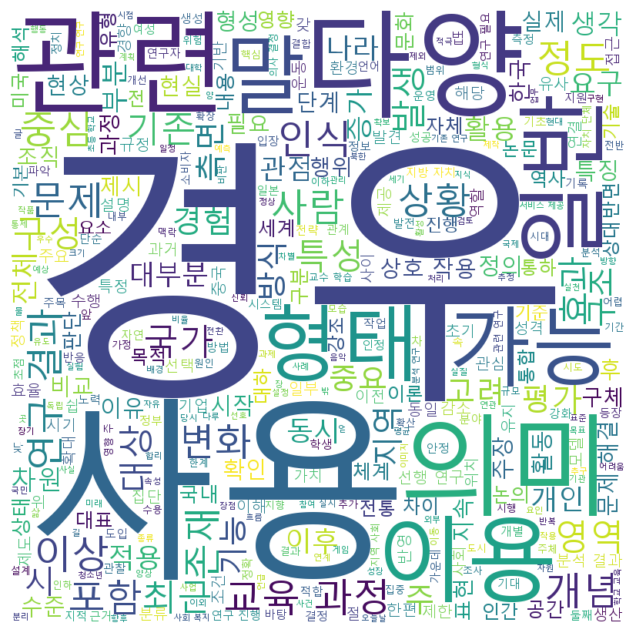

In [42]:
FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

# Combine text with generated value of 0 in dataframe into one string
text_list = df[df["generated"] == 0]['nouns'].tolist()
text = ' '.join([' '.join(item) for item in text_list])

# WordCloud
wc = WordCloud(width=800, height=800, background_color='white', font_path=FONT_PATH, min_font_size=10, max_words=1000)
wc.generate(text)

# Show WordCloud
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Ai

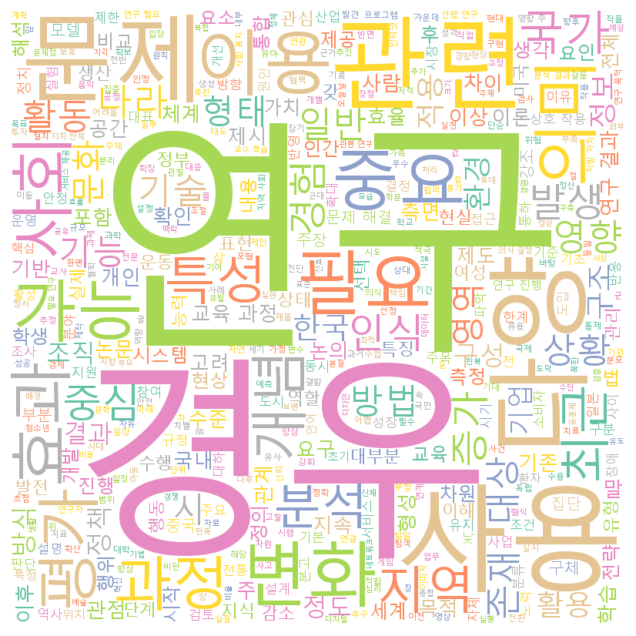

In [43]:
FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

# Combine text with generated value of 1 in dataframe into one string
text_list = df[df["generated"] == 1]['nouns'].tolist()
text = ' '.join([' '.join(item) for item in text_list])

# WordCloud
wc = WordCloud(width=800, height=800, background_color='white', colormap='Set2', font_path=FONT_PATH, min_font_size=10, max_words=1000)
wc.generate(text)

# Show WordCloud
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

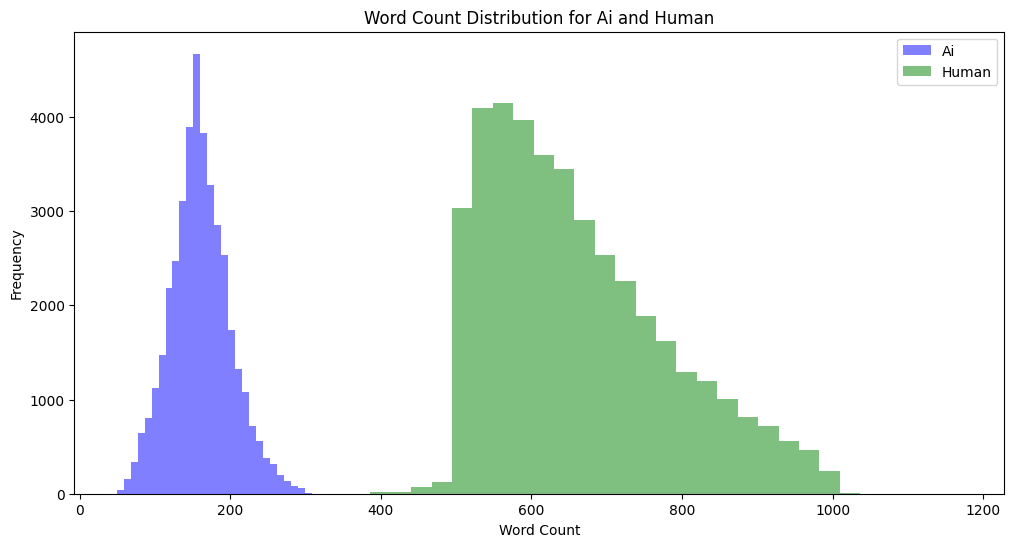

In [44]:
# Extract the Ai and Human essay_word_cnt distributions from the data frame, respectively
ai_word_counts = df[df["generated"] == 1]['essay_word_cnt']
human_word_counts = df[df["generated"] == 0]['essay_word_cnt']

plt.figure(figsize=(12, 6))

# generated == 1 Ai
plt.hist(ai_word_counts, bins=30, alpha=0.5, label='Ai', color='blue')

# generated == 0 Human
plt.hist(human_word_counts, bins=30, alpha=0.5, label='Human', color='green')

plt.title('Word Count Distribution for Ai and Human')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

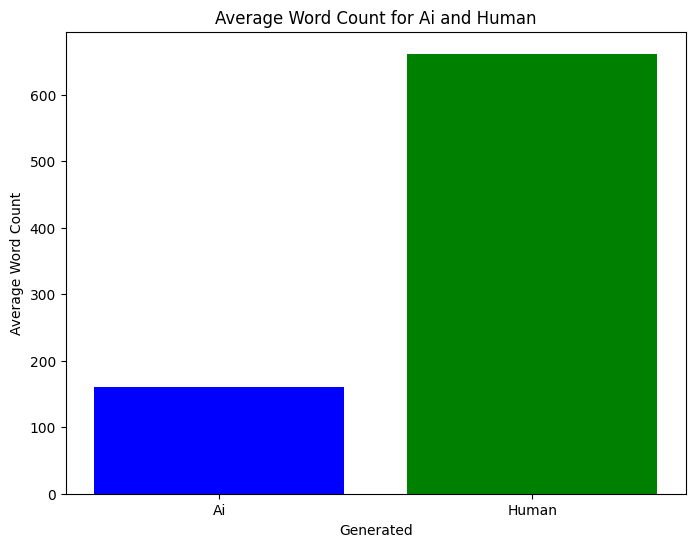

In [45]:
# Calculate the average number of words in each group
ai_mean = df[df["generated"] == 1]['essay_word_cnt'].mean()
human_mean = df[df["generated"] == 0]['essay_word_cnt'].mean()

labels = ['Ai', 'Human']
means = [ai_mean, human_mean]

plt.figure(figsize=(8, 6))
plt.bar(labels, means, color=['blue', 'green'])
plt.title('Average Word Count for Ai and Human')
plt.xlabel('Generated')
plt.ylabel('Average Word Count')
plt.show()

### Split train & test data set

In [46]:
# Create final_df using the converted 'filtered_text' column
final_df = [[text, str(label)] for text, label in zip(df['filtered_text'], df['generated'])]

In [47]:
final_df[:3]

[['고전 문학 교육 고전 시대 문학 교육 양상 살펴보 용어 개념 실제 문화 전통 소중 과거 제도사 학교 제도사 측면 역사 실상 접근 려는 축 중세 글쓰기 양상 간추려 문학 교육 함의 추론 려는 축 연구 성과 축적 교육 제도 변천 중점 두 다면 후자 중세 글쓰기 현재 가치 추출 해 중점 두 고전 시대 문학 교육 양상 등한시 했 결함 나라 중세 시대 문학 지금 위치 차지 했 중세 문인 사회 헤게모니 장악 당연 말 교양 문학 교양 압도 주도 본질 부분 차지 문학 가옥 배열 마을 배치 설명 귀신 내쫓 운명 예견',
  '0'],
 ['일본 조선 침략 이후 조선 개항장 진출 일본인 상업 자본가 소작제 농장 경영 통한 고율 토지 수익 률 확인 미곡 반출 상업 이윤 극대 화 동시 차츰 자본 투자 대상 토지 눈 돌리 일본인 상업 자본가 토지 매수 초기 비옥 삼남 지방 평야 지대 집중 토지 확보 경쟁 가열 범위 점차 서남 해안 도서 지역 확대 조선 농민 토지 조사 사업 이전 토지 소유 권 확대 강화 근거 토지 소유 권 확인 소송 부당 이익 반환 소송 제기 일본인 지주 비합법 토지 매수 맞서 갖가지 반대 운동 전개 조선 통치 사회 경제 기반 식민지 지주 확립 옹호 식민지 권력 토지 가옥 증명 규칙 토지 가옥 소유 권 증명 규칙 공포 일련 토지 법제 개정 일본인 지주 토지 매수 합법 화 최종 토지 조사 사업 실시 토지 소유 권 법률 확정',
  '0'],
 ['주식 시장 주식 가격 등락 완화 가능 가격 형성 안정 성 유지 하루 변동 가격 등락 폭 상하 일정 률 제한 제도 장치 가격 제한 폭 제도 시행 가격 제한 폭 제도 긍정 측면 가격 제한 폭 과도 투기 비롯 합리 못한 가격 형성 방지 단기 주가 등락 막 시장 안정 성 도움 준다는 부정 측면 가격 제한 폭 주가 조정 과정 지연 시켜 시장 효율 성 감소 시킨다는 가격 제한 폭 대한 나라 기존 연구 거래소 시장 연구 이루어져 본 연구 코스닥 시장 경우 분석 해 기존 연구 시장 관찰 변동 성 관측 변동 성 대상 분석 이루어져 관측 

In [48]:
len(final_df)

80000

In [49]:
train_set, val_set = train_test_split(final_df, test_size=0.2, random_state=42, shuffle=True)

In [50]:
print(f"Numbers of train instances by class: {len(train_set)}")
print(f"Numbers of val instances by class: {len(val_set)}")

Numbers of train instances by class: 64000
Numbers of val instances by class: 16000


### Prepare the data as input for the KoBERT model

In [51]:
# Custom tokenizer to handle SentencePiece parameters
class CustomBERTSPTokenizer:
    def __init__(self, tokenizer_path, vocab, lower=False):
        self.tokenizer = nlp.data.BERTSPTokenizer(tokenizer_path, vocab, lower=lower)
        self.sentencepiece = spm.SentencePieceProcessor()
        self.sentencepiece.Load(tokenizer_path)

    def __call__(self, sample, nbest_size=-1, alpha=0.1):
        if isinstance(sample, list):
            sample = sample[0]  # Use the first element of the list
        if not isinstance(sample, str):
            sample = str(sample)
        return self.sentencepiece.SampleEncodeAsPieces(sample, nbest_size, alpha)
    
    @property
    def vocab(self):
        return self.tokenizer.vocab

    def convert_tokens_to_ids(self, tokens):
        if isinstance(tokens[0], list):
            return [self.tokenizer.convert_tokens_to_ids(token) for token in tokens]
        return self.tokenizer.convert_tokens_to_ids(tokens)

# Definition of BERTDataset class (mandatory)
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i] + (self.labels[i], )

    def __len__(self):
        return len(self.labels)

In [52]:
# Setting the hyperparameters
max_len = 256
batch_size = 8
warmup_ratio = 0.1
num_epochs = 4
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [53]:
# Perform the preparation task of the data using class defined above
kobertmodel, vocab = get_pytorch_kobert_model() # calling the bert model and the vocabulary

tokenizer_path = get_tokenizer()
custom_tokenizer = CustomBERTSPTokenizer(tokenizer_path, vocab, lower=False)

# Apply the custom tokenizer with nbest_size and alpha
train_set = BERTDataset(train_set, 0, 1, custom_tokenizer, max_len, True, False)
val_set = BERTDataset(val_set, 0, 1, custom_tokenizer, max_len, True, False)

C:\Users\youji\OneDrive - University of Sussex\Dissertation\.cache\kobert_v1.zip[██████████████████████████████████████████████████]
C:\Users\youji\OneDrive - University of Sussex\Dissertation\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. C:\Users\youji\OneDrive - University of Sussex\Dissertation\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


In [54]:
tokenizer

PreTrainedTokenizer(name_or_path='skt/kobert-base-v1', vocab_size=8002, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [55]:
custom_tokenizer

In [56]:
# verifying the transformation
train_set[1]

(array([   2, 3516, 3513, 6621,  517, 6241, 2860, 6527, 5112, 7276,  517,
        7202, 7782,  517, 6377, 7147, 2355, 7892, 5550, 4483, 5495, 2355,
        7892, 7147,  517, 6377, 5550, 4302, 1406, 5112, 7276, 3516, 7119,
        4484, 1170,  517, 5808, 7044, 3513, 6621, 7119, 4484, 2355, 7892,
         517, 5808, 7044,  517, 7431, 5495, 5524, 5808, 7044, 2423, 6115,
        5782, 4484, 5524, 5808, 7044,  517, 6573, 6137, 3480, 5384, 4596,
         517, 6916, 6844, 4481, 7369, 4128, 7147,  517, 7884,  517, 6364,
        7892, 2573, 5439, 1779, 7369, 4128, 7147, 1682,  517, 7767, 6377,
        7147,  517, 5524, 6122, 4192, 7191,  517, 6599, 7369, 2355, 7892,
        5550, 4302,  517, 6364, 7892, 7147,  517, 7864, 4097,  517, 6364,
        7892, 5550,  517, 7318, 5558, 2617,  517, 6797, 5778, 4297, 5558,
        3516, 7119, 4483, 5495, 5040,  517, 5760, 5782,  517, 6198, 7408,
        2617, 3606, 4128, 5808, 6079, 4004,  953, 7005,  517, 5808, 6335,
        7020,  517, 7096, 6255, 4407, 

In [57]:
# Creating the DataLoaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, num_workers=0, shuffle=False)

### Creation of the KoBERT learing model

In [58]:
torch.cuda.empty_cache()

In [59]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

# Initialize the model with the pre-trained BERT model
kobertmodel, _ = get_pytorch_kobert_model()

# Creation of the model and move it to GPU
model = BERTClassifier(kobertmodel, dr_rate=0.4).to(device)

using cached model. C:\Users\youji\OneDrive - University of Sussex\Dissertation\.cache\kobert_v1.zip
using cached model. C:\Users\youji\OneDrive - University of Sussex\Dissertation\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


In [60]:
%%time
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [61]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [62]:
# configuration f the optimizer and loss function
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [63]:
# define the function to compute the accury of the model
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [64]:
def get_metrics(pred, label, threshold=0.5):
    pred = (pred > threshold).astype('float32')
    tp = ((pred == 1) & (label == 1)).sum()
    fp = ((pred == 1) & (label == 0)).sum()
    fn = ((pred == 0) & (label == 1)).sum()
    tn = ((pred == 0) & (label == 0)).sum()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * recall * precision / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'accuracy': accuracy
    }

### Training the KoBERT model

In [65]:
torch.cuda.empty_cache()

In [66]:
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved. Default: 2
            verbose (bool): If True, prints a message for each validation loss improvement. Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement. Default: 0
            path (str): Path for the checkpoint to be saved to. Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        """
        Call method to check if the validation loss has improved and handle early stopping.
        Args:
            val_loss (float): Current validation loss
            model (torch.nn.Module): Model to save if validation loss decreases
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [67]:
%%time
from time import time

train_accuracies = []
train_losses = []

if __name__ == "__main__":
    start_time = time()  # Record the start time

    for e in range(num_epochs):
        train_acc = 0.0
        train_loss = 0.0

        model.train()  # Set the model to training mode
        print(f"Starting epoch {e+1}/{num_epochs}...")
        epoch_start_time = time()  # Record the start time of the epoch
        for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training"):
            optimizer.zero_grad()  # Zero the gradients
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            loss = loss_fn(out, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip the gradients to avoid exploding gradients
            optimizer.step()  # Update the parameters
            scheduler.step()  # Update learning rate schedule
            train_acc += calc_accuracy(out, label)  # Calculate accuracy
            train_loss += loss.item()  # Accumulate loss
            if (batch_id + 1) % log_interval == 0:
                print(f"Epoch {e+1}, Batch {batch_id+1}/{len(train_dataloader)}: Loss = {loss.data.cpu().numpy():.4f}, Train Acc = {train_acc / (batch_id+1):.4f}")
        train_accuracies.append(train_acc / len(train_dataloader))  # Record training accuracy for the epoch
        train_losses.append(train_loss / len(train_dataloader))  # Record training loss for the epoch
        print(f"Epoch {e+1} Train Acc: {train_acc / len(train_dataloader):.4f}")

        # Save the model at the end of each epoch
        torch.save(model.state_dict(), f'model_epoch_{e+1}.pth')

    run_time = time() - start_time  # Calculate total training time
    print(f"Total training time: {run_time:.2f} seconds.")

Starting epoch 1/4...


Training:   2%|█▋                                                                 | 200/8000 [04:18<2:47:18,  1.29s/it]

Epoch 1, Batch 200/8000: Loss = 0.1232, Train Acc = 0.7569


Training:   5%|███▎                                                               | 400/8000 [08:36<2:43:47,  1.29s/it]

Epoch 1, Batch 400/8000: Loss = 0.0070, Train Acc = 0.8750


Training:   8%|█████                                                              | 600/8000 [12:55<2:38:44,  1.29s/it]

Epoch 1, Batch 600/8000: Loss = 0.0020, Train Acc = 0.9160


Training:  10%|██████▋                                                            | 800/8000 [17:14<2:35:13,  1.29s/it]

Epoch 1, Batch 800/8000: Loss = 0.0014, Train Acc = 0.9359


Training:  12%|████████▎                                                         | 1000/8000 [21:32<2:30:05,  1.29s/it]

Epoch 1, Batch 1000/8000: Loss = 0.0010, Train Acc = 0.9481


Training:  15%|█████████▉                                                        | 1200/8000 [25:50<2:26:29,  1.29s/it]

Epoch 1, Batch 1200/8000: Loss = 0.0022, Train Acc = 0.9558


Training:  18%|███████████▌                                                      | 1400/8000 [30:08<2:21:53,  1.29s/it]

Epoch 1, Batch 1400/8000: Loss = 0.0004, Train Acc = 0.9620


Training:  20%|█████████████▏                                                    | 1600/8000 [34:26<2:17:36,  1.29s/it]

Epoch 1, Batch 1600/8000: Loss = 0.0002, Train Acc = 0.9666


Training:  22%|██████████████▊                                                   | 1800/8000 [38:45<2:13:08,  1.29s/it]

Epoch 1, Batch 1800/8000: Loss = 0.0004, Train Acc = 0.9701


Training:  25%|████████████████▌                                                 | 2000/8000 [43:03<2:09:48,  1.30s/it]

Epoch 1, Batch 2000/8000: Loss = 0.0036, Train Acc = 0.9725


Training:  28%|██████████████████▏                                               | 2200/8000 [47:21<2:04:20,  1.29s/it]

Epoch 1, Batch 2200/8000: Loss = 0.0002, Train Acc = 0.9748


Training:  30%|███████████████████▊                                              | 2400/8000 [51:40<2:00:35,  1.29s/it]

Epoch 1, Batch 2400/8000: Loss = 0.0005, Train Acc = 0.9763


Training:  32%|█████████████████████▍                                            | 2600/8000 [55:58<1:56:16,  1.29s/it]

Epoch 1, Batch 2600/8000: Loss = 0.0002, Train Acc = 0.9779


Training:  35%|██████████████████████▍                                         | 2800/8000 [1:00:17<1:51:51,  1.29s/it]

Epoch 1, Batch 2800/8000: Loss = 0.0004, Train Acc = 0.9789


Training:  38%|████████████████████████                                        | 3000/8000 [1:04:35<1:47:38,  1.29s/it]

Epoch 1, Batch 3000/8000: Loss = 0.0015, Train Acc = 0.9800


Training:  40%|█████████████████████████▌                                      | 3200/8000 [1:08:53<1:42:48,  1.29s/it]

Epoch 1, Batch 3200/8000: Loss = 0.0016, Train Acc = 0.9807


Training:  42%|███████████████████████████▏                                    | 3400/8000 [1:13:11<1:39:03,  1.29s/it]

Epoch 1, Batch 3400/8000: Loss = 0.0011, Train Acc = 0.9815


Training:  45%|████████████████████████████▊                                   | 3600/8000 [1:17:30<1:34:48,  1.29s/it]

Epoch 1, Batch 3600/8000: Loss = 0.0007, Train Acc = 0.9824


Training:  48%|██████████████████████████████▍                                 | 3800/8000 [1:21:48<1:30:42,  1.30s/it]

Epoch 1, Batch 3800/8000: Loss = 0.0014, Train Acc = 0.9830


Training:  50%|████████████████████████████████                                | 4000/8000 [1:26:06<1:25:44,  1.29s/it]

Epoch 1, Batch 4000/8000: Loss = 0.0002, Train Acc = 0.9838


Training:  52%|█████████████████████████████████▌                              | 4200/8000 [1:30:24<1:21:44,  1.29s/it]

Epoch 1, Batch 4200/8000: Loss = 0.0025, Train Acc = 0.9843


Training:  55%|███████████████████████████████████▏                            | 4400/8000 [1:34:43<1:18:12,  1.30s/it]

Epoch 1, Batch 4400/8000: Loss = 0.0005, Train Acc = 0.9849


Training:  57%|████████████████████████████████████▊                           | 4600/8000 [1:39:01<1:12:59,  1.29s/it]

Epoch 1, Batch 4600/8000: Loss = 0.0034, Train Acc = 0.9854


Training:  60%|██████████████████████████████████████▍                         | 4800/8000 [1:43:19<1:08:57,  1.29s/it]

Epoch 1, Batch 4800/8000: Loss = 0.0012, Train Acc = 0.9856


Training:  62%|████████████████████████████████████████                        | 5000/8000 [1:47:36<1:04:13,  1.28s/it]

Epoch 1, Batch 5000/8000: Loss = 0.0017, Train Acc = 0.9859


Training:  65%|██████████████████████████████████████████▉                       | 5200/8000 [1:51:54<59:58,  1.29s/it]

Epoch 1, Batch 5200/8000: Loss = 0.0035, Train Acc = 0.9862


Training:  68%|████████████████████████████████████████████▌                     | 5400/8000 [1:56:11<55:26,  1.28s/it]

Epoch 1, Batch 5400/8000: Loss = 0.0011, Train Acc = 0.9865


Training:  70%|██████████████████████████████████████████████▏                   | 5600/8000 [2:00:27<53:26,  1.34s/it]

Epoch 1, Batch 5600/8000: Loss = 0.0012, Train Acc = 0.9867


Training:  72%|███████████████████████████████████████████████▊                  | 5800/8000 [2:04:45<47:18,  1.29s/it]

Epoch 1, Batch 5800/8000: Loss = 0.0014, Train Acc = 0.9869


Training:  75%|█████████████████████████████████████████████████▌                | 6000/8000 [2:09:02<43:01,  1.29s/it]

Epoch 1, Batch 6000/8000: Loss = 0.0013, Train Acc = 0.9872


Training:  78%|███████████████████████████████████████████████████▏              | 6200/8000 [2:13:19<38:23,  1.28s/it]

Epoch 1, Batch 6200/8000: Loss = 0.0007, Train Acc = 0.9875


Training:  80%|████████████████████████████████████████████████████▊             | 6400/8000 [2:17:36<34:19,  1.29s/it]

Epoch 1, Batch 6400/8000: Loss = 0.0008, Train Acc = 0.9877


Training:  82%|██████████████████████████████████████████████████████▍           | 6600/8000 [2:21:53<29:59,  1.29s/it]

Epoch 1, Batch 6600/8000: Loss = 0.0003, Train Acc = 0.9880


Training:  85%|████████████████████████████████████████████████████████          | 6800/8000 [2:26:10<25:45,  1.29s/it]

Epoch 1, Batch 6800/8000: Loss = 0.0009, Train Acc = 0.9883


Training:  88%|█████████████████████████████████████████████████████████▊        | 7000/8000 [2:30:27<21:24,  1.28s/it]

Epoch 1, Batch 7000/8000: Loss = 0.7431, Train Acc = 0.9755


Training:  90%|███████████████████████████████████████████████████████████▍      | 7200/8000 [2:34:45<17:06,  1.28s/it]

Epoch 1, Batch 7200/8000: Loss = 0.0038, Train Acc = 0.9645


Training:  92%|█████████████████████████████████████████████████████████████     | 7400/8000 [2:39:01<12:48,  1.28s/it]

Epoch 1, Batch 7400/8000: Loss = 0.0008, Train Acc = 0.9653


Training:  95%|██████████████████████████████████████████████████████████████▋   | 7600/8000 [2:43:18<08:34,  1.29s/it]

Epoch 1, Batch 7600/8000: Loss = 0.0021, Train Acc = 0.9661


Training:  98%|████████████████████████████████████████████████████████████████▎ | 7800/8000 [2:47:35<04:15,  1.28s/it]

Epoch 1, Batch 7800/8000: Loss = 0.0012, Train Acc = 0.9668


Training: 100%|██████████████████████████████████████████████████████████████████| 8000/8000 [2:51:51<00:00,  1.29s/it]

Epoch 1, Batch 8000/8000: Loss = 0.0009, Train Acc = 0.9675
Epoch 1 Train Acc: 0.9675


Starting epoch 2/4...


Training:   2%|█▋                                                                 | 200/8000 [04:16<2:46:24,  1.28s/it]

Epoch 2, Batch 200/8000: Loss = 0.0015, Train Acc = 0.9938


Training:   5%|███▎                                                               | 400/8000 [08:33<2:42:35,  1.28s/it]

Epoch 2, Batch 400/8000: Loss = 0.0009, Train Acc = 0.9944


Training:   8%|█████                                                              | 600/8000 [12:49<2:37:37,  1.28s/it]

Epoch 2, Batch 600/8000: Loss = 0.0008, Train Acc = 0.9950


Training:  10%|██████▋                                                            | 800/8000 [17:06<2:34:05,  1.28s/it]

Epoch 2, Batch 800/8000: Loss = 0.0013, Train Acc = 0.9938


Training:  12%|████████▎                                                         | 1000/8000 [21:22<2:29:05,  1.28s/it]

Epoch 2, Batch 1000/8000: Loss = 0.0010, Train Acc = 0.9936


Training:  15%|█████████▉                                                        | 1200/8000 [25:39<2:25:10,  1.28s/it]

Epoch 2, Batch 1200/8000: Loss = 0.8070, Train Acc = 0.9935


Training:  18%|███████████▌                                                      | 1400/8000 [29:55<2:21:28,  1.29s/it]

Epoch 2, Batch 1400/8000: Loss = 0.0031, Train Acc = 0.9934


Training:  20%|█████████████▏                                                    | 1600/8000 [34:12<2:16:44,  1.28s/it]

Epoch 2, Batch 1600/8000: Loss = 0.0033, Train Acc = 0.9936


Training:  22%|██████████████▊                                                   | 1800/8000 [38:29<2:12:27,  1.28s/it]

Epoch 2, Batch 1800/8000: Loss = 0.0010, Train Acc = 0.9938


Training:  25%|████████████████▌                                                 | 2000/8000 [42:46<2:08:44,  1.29s/it]

Epoch 2, Batch 2000/8000: Loss = 0.0012, Train Acc = 0.9938


Training:  28%|██████████████████▏                                               | 2200/8000 [47:03<2:04:12,  1.28s/it]

Epoch 2, Batch 2200/8000: Loss = 0.0010, Train Acc = 0.9938


Training:  30%|███████████████████▊                                              | 2400/8000 [51:20<1:59:59,  1.29s/it]

Epoch 2, Batch 2400/8000: Loss = 0.0015, Train Acc = 0.9939


Training:  32%|█████████████████████▍                                            | 2600/8000 [55:37<1:55:53,  1.29s/it]

Epoch 2, Batch 2600/8000: Loss = 0.0015, Train Acc = 0.9941


Training:  35%|███████████████████████                                           | 2800/8000 [59:54<1:51:16,  1.28s/it]

Epoch 2, Batch 2800/8000: Loss = 0.0007, Train Acc = 0.9943


Training:  38%|████████████████████████                                        | 3000/8000 [1:04:11<1:47:25,  1.29s/it]

Epoch 2, Batch 3000/8000: Loss = 0.0028, Train Acc = 0.9940


Training:  40%|█████████████████████████▌                                      | 3200/8000 [1:08:30<1:43:53,  1.30s/it]

Epoch 2, Batch 3200/8000: Loss = 0.0010, Train Acc = 0.9939


Training:  42%|███████████████████████████▏                                    | 3400/8000 [1:12:48<1:38:55,  1.29s/it]

Epoch 2, Batch 3400/8000: Loss = 0.0025, Train Acc = 0.9938


Training:  45%|████████████████████████████▊                                   | 3600/8000 [1:17:05<1:34:39,  1.29s/it]

Epoch 2, Batch 3600/8000: Loss = 0.7878, Train Acc = 0.9939


Training:  48%|██████████████████████████████▍                                 | 3800/8000 [1:21:23<1:30:18,  1.29s/it]

Epoch 2, Batch 3800/8000: Loss = 0.0028, Train Acc = 0.9938


Training:  50%|████████████████████████████████                                | 4000/8000 [1:25:40<1:25:57,  1.29s/it]

Epoch 2, Batch 4000/8000: Loss = 0.0009, Train Acc = 0.9939


Training:  52%|█████████████████████████████████▌                              | 4200/8000 [1:29:57<1:21:24,  1.29s/it]

Epoch 2, Batch 4200/8000: Loss = 0.0015, Train Acc = 0.9940


Training:  55%|███████████████████████████████████▏                            | 4400/8000 [1:34:14<1:17:06,  1.29s/it]

Epoch 2, Batch 4400/8000: Loss = 0.0006, Train Acc = 0.9940


Training:  57%|████████████████████████████████████▊                           | 4600/8000 [1:38:32<1:12:54,  1.29s/it]

Epoch 2, Batch 4600/8000: Loss = 0.0011, Train Acc = 0.9939


Training:  60%|██████████████████████████████████████▍                         | 4800/8000 [1:42:49<1:08:39,  1.29s/it]

Epoch 2, Batch 4800/8000: Loss = 0.0019, Train Acc = 0.9938


Training:  62%|████████████████████████████████████████                        | 5000/8000 [1:47:06<1:04:26,  1.29s/it]

Epoch 2, Batch 5000/8000: Loss = 0.7164, Train Acc = 0.9938


Training:  65%|█████████████████████████████████████████▌                      | 5200/8000 [1:51:24<1:00:01,  1.29s/it]

Epoch 2, Batch 5200/8000: Loss = 0.0009, Train Acc = 0.9938


Training:  68%|████████████████████████████████████████████▌                     | 5400/8000 [1:55:41<55:52,  1.29s/it]

Epoch 2, Batch 5400/8000: Loss = 0.0016, Train Acc = 0.9938


Training:  70%|██████████████████████████████████████████████▏                   | 5600/8000 [1:59:58<51:20,  1.28s/it]

Epoch 2, Batch 5600/8000: Loss = 0.0023, Train Acc = 0.9938


Training:  72%|███████████████████████████████████████████████▊                  | 5800/8000 [2:04:16<47:13,  1.29s/it]

Epoch 2, Batch 5800/8000: Loss = 0.0015, Train Acc = 0.9938


Training:  75%|█████████████████████████████████████████████████▌                | 6000/8000 [2:08:33<42:53,  1.29s/it]

Epoch 2, Batch 6000/8000: Loss = 0.0007, Train Acc = 0.9939


Training:  78%|███████████████████████████████████████████████████▏              | 6200/8000 [2:12:50<38:28,  1.28s/it]

Epoch 2, Batch 6200/8000: Loss = 0.0027, Train Acc = 0.9938


Training:  80%|████████████████████████████████████████████████████▊             | 6400/8000 [2:17:07<34:18,  1.29s/it]

Epoch 2, Batch 6400/8000: Loss = 0.0034, Train Acc = 0.9938


Training:  82%|██████████████████████████████████████████████████████▍           | 6600/8000 [2:21:24<30:06,  1.29s/it]

Epoch 2, Batch 6600/8000: Loss = 0.0010, Train Acc = 0.9939


Training:  85%|████████████████████████████████████████████████████████          | 6800/8000 [2:25:41<25:37,  1.28s/it]

Epoch 2, Batch 6800/8000: Loss = 0.0014, Train Acc = 0.9939


Training:  88%|█████████████████████████████████████████████████████████▊        | 7000/8000 [2:29:58<21:26,  1.29s/it]

Epoch 2, Batch 7000/8000: Loss = 0.0018, Train Acc = 0.9939


Training:  90%|███████████████████████████████████████████████████████████▍      | 7200/8000 [2:34:16<17:10,  1.29s/it]

Epoch 2, Batch 7200/8000: Loss = 0.0008, Train Acc = 0.9939


Training:  92%|█████████████████████████████████████████████████████████████     | 7400/8000 [2:38:33<12:50,  1.28s/it]

Epoch 2, Batch 7400/8000: Loss = 0.0008, Train Acc = 0.9940


Training:  95%|██████████████████████████████████████████████████████████████▋   | 7600/8000 [2:42:50<08:33,  1.28s/it]

Epoch 2, Batch 7600/8000: Loss = 0.0020, Train Acc = 0.9940


Training:  98%|████████████████████████████████████████████████████████████████▎ | 7800/8000 [2:47:07<04:17,  1.29s/it]

Epoch 2, Batch 7800/8000: Loss = 0.0050, Train Acc = 0.9940


Training: 100%|██████████████████████████████████████████████████████████████████| 8000/8000 [2:51:25<00:00,  1.29s/it]

Epoch 2, Batch 8000/8000: Loss = 0.0012, Train Acc = 0.9941
Epoch 2 Train Acc: 0.9941


Starting epoch 3/4...


Training:   2%|█▋                                                                 | 200/8000 [04:17<2:47:41,  1.29s/it]

Epoch 3, Batch 200/8000: Loss = 0.0011, Train Acc = 0.9956


Training:   5%|███▎                                                               | 400/8000 [08:34<2:42:46,  1.29s/it]

Epoch 3, Batch 400/8000: Loss = 0.0026, Train Acc = 0.9953


Training:   8%|█████                                                              | 600/8000 [12:52<2:38:31,  1.29s/it]

Epoch 3, Batch 600/8000: Loss = 0.0017, Train Acc = 0.9952


Training:  10%|██████▋                                                            | 800/8000 [17:09<2:34:15,  1.29s/it]

Epoch 3, Batch 800/8000: Loss = 0.0012, Train Acc = 0.9947


Training:  12%|████████▎                                                         | 1000/8000 [21:26<2:30:21,  1.29s/it]

Epoch 3, Batch 1000/8000: Loss = 0.0017, Train Acc = 0.9946


Training:  15%|█████████▉                                                        | 1200/8000 [25:44<2:25:58,  1.29s/it]

Epoch 3, Batch 1200/8000: Loss = 0.0023, Train Acc = 0.9945


Training:  18%|███████████▌                                                      | 1400/8000 [30:01<2:21:20,  1.28s/it]

Epoch 3, Batch 1400/8000: Loss = 0.0015, Train Acc = 0.9948


Training:  20%|█████████████▏                                                    | 1600/8000 [34:18<2:16:45,  1.28s/it]

Epoch 3, Batch 1600/8000: Loss = 0.0007, Train Acc = 0.9949


Training:  22%|██████████████▊                                                   | 1800/8000 [38:35<2:12:48,  1.29s/it]

Epoch 3, Batch 1800/8000: Loss = 0.0015, Train Acc = 0.9949


Training:  25%|████████████████▌                                                 | 2000/8000 [42:53<2:08:58,  1.29s/it]

Epoch 3, Batch 2000/8000: Loss = 1.0487, Train Acc = 0.9948


Training:  28%|██████████████████▏                                               | 2200/8000 [47:10<2:04:28,  1.29s/it]

Epoch 3, Batch 2200/8000: Loss = 0.0006, Train Acc = 0.9951


Training:  30%|███████████████████▊                                              | 2400/8000 [51:27<2:00:04,  1.29s/it]

Epoch 3, Batch 2400/8000: Loss = 0.0025, Train Acc = 0.9946


Training:  32%|█████████████████████▍                                            | 2600/8000 [55:44<1:56:09,  1.29s/it]

Epoch 3, Batch 2600/8000: Loss = 0.7264, Train Acc = 0.9945


Training:  35%|██████████████████████▍                                         | 2800/8000 [1:00:02<1:51:00,  1.28s/it]

Epoch 3, Batch 2800/8000: Loss = 0.0011, Train Acc = 0.9945


Training:  38%|████████████████████████                                        | 3000/8000 [1:04:19<1:47:15,  1.29s/it]

Epoch 3, Batch 3000/8000: Loss = 0.9777, Train Acc = 0.9943


Training:  40%|█████████████████████████▌                                      | 3200/8000 [1:08:36<1:42:46,  1.28s/it]

Epoch 3, Batch 3200/8000: Loss = 0.0006, Train Acc = 0.9944


Training:  42%|███████████████████████████▏                                    | 3400/8000 [1:12:53<1:38:24,  1.28s/it]

Epoch 3, Batch 3400/8000: Loss = 0.0017, Train Acc = 0.9944


Training:  45%|████████████████████████████▊                                   | 3600/8000 [1:17:11<1:34:42,  1.29s/it]

Epoch 3, Batch 3600/8000: Loss = 0.0024, Train Acc = 0.9944


Training:  48%|██████████████████████████████▍                                 | 3800/8000 [1:21:28<1:30:00,  1.29s/it]

Epoch 3, Batch 3800/8000: Loss = 0.0019, Train Acc = 0.9942


Training:  50%|████████████████████████████████                                | 4000/8000 [1:25:45<1:25:32,  1.28s/it]

Epoch 3, Batch 4000/8000: Loss = 0.0014, Train Acc = 0.9942


Training:  52%|█████████████████████████████████▌                              | 4200/8000 [1:30:02<1:21:31,  1.29s/it]

Epoch 3, Batch 4200/8000: Loss = 0.0014, Train Acc = 0.9943


Training:  55%|███████████████████████████████████▏                            | 4400/8000 [1:34:20<1:17:14,  1.29s/it]

Epoch 3, Batch 4400/8000: Loss = 0.0021, Train Acc = 0.9942


Training:  57%|████████████████████████████████████▊                           | 4600/8000 [1:38:37<1:12:41,  1.28s/it]

Epoch 3, Batch 4600/8000: Loss = 0.0005, Train Acc = 0.9942


Training:  60%|██████████████████████████████████████▍                         | 4800/8000 [1:42:55<1:08:48,  1.29s/it]

Epoch 3, Batch 4800/8000: Loss = 0.0016, Train Acc = 0.9943


Training:  62%|████████████████████████████████████████                        | 5000/8000 [1:47:12<1:04:27,  1.29s/it]

Epoch 3, Batch 5000/8000: Loss = 0.0023, Train Acc = 0.9942


Training:  65%|██████████████████████████████████████████▉                       | 5200/8000 [1:51:29<59:51,  1.28s/it]

Epoch 3, Batch 5200/8000: Loss = 0.0019, Train Acc = 0.9941


Training:  68%|████████████████████████████████████████████▌                     | 5400/8000 [1:55:47<55:35,  1.28s/it]

Epoch 3, Batch 5400/8000: Loss = 0.0027, Train Acc = 0.9941


Training:  70%|██████████████████████████████████████████████▏                   | 5600/8000 [2:00:04<51:19,  1.28s/it]

Epoch 3, Batch 5600/8000: Loss = 0.0012, Train Acc = 0.9941


Training:  72%|███████████████████████████████████████████████▊                  | 5800/8000 [2:04:21<47:05,  1.28s/it]

Epoch 3, Batch 5800/8000: Loss = 0.0023, Train Acc = 0.9942


Training:  75%|█████████████████████████████████████████████████▌                | 6000/8000 [2:08:38<42:50,  1.29s/it]

Epoch 3, Batch 6000/8000: Loss = 0.7190, Train Acc = 0.9941


Training:  78%|███████████████████████████████████████████████████▏              | 6200/8000 [2:12:56<38:33,  1.29s/it]

Epoch 3, Batch 6200/8000: Loss = 0.0023, Train Acc = 0.9940


Training:  80%|████████████████████████████████████████████████████▊             | 6400/8000 [2:17:13<34:19,  1.29s/it]

Epoch 3, Batch 6400/8000: Loss = 0.0026, Train Acc = 0.9941


Training:  82%|██████████████████████████████████████████████████████▍           | 6600/8000 [2:21:30<30:04,  1.29s/it]

Epoch 3, Batch 6600/8000: Loss = 0.6668, Train Acc = 0.9941


Training:  85%|████████████████████████████████████████████████████████          | 6800/8000 [2:25:47<25:42,  1.29s/it]

Epoch 3, Batch 6800/8000: Loss = 0.0017, Train Acc = 0.9941


Training:  88%|█████████████████████████████████████████████████████████▊        | 7000/8000 [2:30:05<21:26,  1.29s/it]

Epoch 3, Batch 7000/8000: Loss = 0.0017, Train Acc = 0.9941


Training:  90%|███████████████████████████████████████████████████████████▍      | 7200/8000 [2:34:22<17:10,  1.29s/it]

Epoch 3, Batch 7200/8000: Loss = 0.0018, Train Acc = 0.9940


Training:  92%|█████████████████████████████████████████████████████████████     | 7400/8000 [2:38:40<12:49,  1.28s/it]

Epoch 3, Batch 7400/8000: Loss = 0.0024, Train Acc = 0.9940


Training:  95%|██████████████████████████████████████████████████████████████▋   | 7600/8000 [2:42:57<08:33,  1.28s/it]

Epoch 3, Batch 7600/8000: Loss = 0.0011, Train Acc = 0.9940


Training:  98%|████████████████████████████████████████████████████████████████▎ | 7800/8000 [2:47:14<04:17,  1.29s/it]

Epoch 3, Batch 7800/8000: Loss = 0.0009, Train Acc = 0.9942


Training: 100%|██████████████████████████████████████████████████████████████████| 8000/8000 [2:51:31<00:00,  1.29s/it]

Epoch 3, Batch 8000/8000: Loss = 0.0017, Train Acc = 0.9941
Epoch 3 Train Acc: 0.9941


Starting epoch 4/4...


Training:   2%|█▋                                                                 | 200/8000 [04:17<2:47:12,  1.29s/it]

Epoch 4, Batch 200/8000: Loss = 0.0019, Train Acc = 0.9938


Training:   5%|███▎                                                               | 400/8000 [08:34<2:42:00,  1.28s/it]

Epoch 4, Batch 400/8000: Loss = 0.0004, Train Acc = 0.9922


Training:   8%|█████                                                              | 600/8000 [12:51<2:38:59,  1.29s/it]

Epoch 4, Batch 600/8000: Loss = 0.0015, Train Acc = 0.9940


Training:  10%|██████▋                                                            | 800/8000 [17:09<2:34:25,  1.29s/it]

Epoch 4, Batch 800/8000: Loss = 0.0011, Train Acc = 0.9934


Training:  12%|████████▎                                                         | 1000/8000 [21:26<2:29:49,  1.28s/it]

Epoch 4, Batch 1000/8000: Loss = 0.0020, Train Acc = 0.9932


Training:  15%|█████████▉                                                        | 1200/8000 [25:44<2:27:05,  1.30s/it]

Epoch 4, Batch 1200/8000: Loss = 0.0025, Train Acc = 0.9939


Training:  18%|███████████▌                                                      | 1400/8000 [30:01<2:21:32,  1.29s/it]

Epoch 4, Batch 1400/8000: Loss = 0.0022, Train Acc = 0.9939


Training:  20%|█████████████▏                                                    | 1600/8000 [34:18<2:17:46,  1.29s/it]

Epoch 4, Batch 1600/8000: Loss = 0.0016, Train Acc = 0.9939


Training:  22%|██████████████▊                                                   | 1800/8000 [38:36<2:13:11,  1.29s/it]

Epoch 4, Batch 1800/8000: Loss = 0.0015, Train Acc = 0.9939


Training:  25%|████████████████▌                                                 | 2000/8000 [42:53<2:09:05,  1.29s/it]

Epoch 4, Batch 2000/8000: Loss = 0.0013, Train Acc = 0.9938


Training:  28%|██████████████████▏                                               | 2200/8000 [47:10<2:03:57,  1.28s/it]

Epoch 4, Batch 2200/8000: Loss = 0.0009, Train Acc = 0.9941


Training:  30%|███████████████████▊                                              | 2400/8000 [51:28<2:00:20,  1.29s/it]

Epoch 4, Batch 2400/8000: Loss = 0.0018, Train Acc = 0.9940


Training:  32%|█████████████████████▍                                            | 2600/8000 [55:46<1:55:59,  1.29s/it]

Epoch 4, Batch 2600/8000: Loss = 0.0003, Train Acc = 0.9938


Training:  35%|██████████████████████▍                                         | 2800/8000 [1:00:03<1:51:39,  1.29s/it]

Epoch 4, Batch 2800/8000: Loss = 0.0012, Train Acc = 0.9940


Training:  38%|████████████████████████                                        | 3000/8000 [1:04:20<1:46:51,  1.28s/it]

Epoch 4, Batch 3000/8000: Loss = 0.0008, Train Acc = 0.9942


Training:  40%|█████████████████████████▌                                      | 3200/8000 [1:08:37<1:43:02,  1.29s/it]

Epoch 4, Batch 3200/8000: Loss = 0.0007, Train Acc = 0.9944


Training:  42%|███████████████████████████▏                                    | 3400/8000 [1:12:55<1:38:10,  1.28s/it]

Epoch 4, Batch 3400/8000: Loss = 0.0008, Train Acc = 0.9944


Training:  45%|████████████████████████████▊                                   | 3600/8000 [1:17:12<1:34:13,  1.28s/it]

Epoch 4, Batch 3600/8000: Loss = 0.0019, Train Acc = 0.9944


Training:  48%|██████████████████████████████▍                                 | 3800/8000 [1:21:29<1:30:02,  1.29s/it]

Epoch 4, Batch 3800/8000: Loss = 0.0012, Train Acc = 0.9943


Training:  50%|████████████████████████████████                                | 4000/8000 [1:25:46<1:25:50,  1.29s/it]

Epoch 4, Batch 4000/8000: Loss = 0.0005, Train Acc = 0.9944


Training:  52%|█████████████████████████████████▌                              | 4200/8000 [1:30:03<1:21:07,  1.28s/it]

Epoch 4, Batch 4200/8000: Loss = 0.0014, Train Acc = 0.9943


Training:  55%|███████████████████████████████████▏                            | 4400/8000 [1:34:20<1:17:12,  1.29s/it]

Epoch 4, Batch 4400/8000: Loss = 0.0018, Train Acc = 0.9943


Training:  57%|████████████████████████████████████▊                           | 4600/8000 [1:38:37<1:12:38,  1.28s/it]

Epoch 4, Batch 4600/8000: Loss = 0.0012, Train Acc = 0.9945


Training:  60%|██████████████████████████████████████▍                         | 4800/8000 [1:42:54<1:08:32,  1.29s/it]

Epoch 4, Batch 4800/8000: Loss = 0.0012, Train Acc = 0.9944


Training:  62%|████████████████████████████████████████                        | 5000/8000 [1:47:10<1:04:04,  1.28s/it]

Epoch 4, Batch 5000/8000: Loss = 0.0009, Train Acc = 0.9943


Training:  65%|█████████████████████████████████████████▌                      | 5200/8000 [1:51:27<1:00:01,  1.29s/it]

Epoch 4, Batch 5200/8000: Loss = 0.0025, Train Acc = 0.9943


Training:  68%|████████████████████████████████████████████▌                     | 5400/8000 [1:55:45<55:58,  1.29s/it]

Epoch 4, Batch 5400/8000: Loss = 0.6574, Train Acc = 0.9941


Training:  70%|██████████████████████████████████████████████▏                   | 5600/8000 [2:00:02<51:18,  1.28s/it]

Epoch 4, Batch 5600/8000: Loss = 0.0007, Train Acc = 0.9941


Training:  72%|███████████████████████████████████████████████▊                  | 5800/8000 [2:04:19<47:16,  1.29s/it]

Epoch 4, Batch 5800/8000: Loss = 0.0016, Train Acc = 0.9941


Training:  75%|█████████████████████████████████████████████████▌                | 6000/8000 [2:08:36<42:52,  1.29s/it]

Epoch 4, Batch 6000/8000: Loss = 0.0022, Train Acc = 0.9941


Training:  78%|███████████████████████████████████████████████████▏              | 6200/8000 [2:12:53<38:29,  1.28s/it]

Epoch 4, Batch 6200/8000: Loss = 0.0012, Train Acc = 0.9941


Training:  80%|████████████████████████████████████████████████████▊             | 6400/8000 [2:17:10<34:17,  1.29s/it]

Epoch 4, Batch 6400/8000: Loss = 0.0014, Train Acc = 0.9940


Training:  82%|██████████████████████████████████████████████████████▍           | 6600/8000 [2:21:27<30:06,  1.29s/it]

Epoch 4, Batch 6600/8000: Loss = 0.0018, Train Acc = 0.9940


Training:  85%|████████████████████████████████████████████████████████          | 6800/8000 [2:25:44<25:43,  1.29s/it]

Epoch 4, Batch 6800/8000: Loss = 0.0013, Train Acc = 0.9941


Training:  88%|█████████████████████████████████████████████████████████▊        | 7000/8000 [2:30:02<21:26,  1.29s/it]

Epoch 4, Batch 7000/8000: Loss = 0.7169, Train Acc = 0.9940


Training:  90%|███████████████████████████████████████████████████████████▍      | 7200/8000 [2:34:19<17:07,  1.28s/it]

Epoch 4, Batch 7200/8000: Loss = 0.0013, Train Acc = 0.9941


Training:  92%|█████████████████████████████████████████████████████████████     | 7400/8000 [2:38:36<12:52,  1.29s/it]

Epoch 4, Batch 7400/8000: Loss = 0.0026, Train Acc = 0.9941


Training:  95%|██████████████████████████████████████████████████████████████▋   | 7600/8000 [2:42:54<08:35,  1.29s/it]

Epoch 4, Batch 7600/8000: Loss = 0.0021, Train Acc = 0.9941


Training:  98%|████████████████████████████████████████████████████████████████▎ | 7800/8000 [2:47:11<04:17,  1.29s/it]

Epoch 4, Batch 7800/8000: Loss = 0.0026, Train Acc = 0.9941


Training: 100%|██████████████████████████████████████████████████████████████████| 8000/8000 [2:51:29<00:00,  1.29s/it]

Epoch 4, Batch 8000/8000: Loss = 0.0020, Train Acc = 0.9941
Epoch 4 Train Acc: 0.9941


Total training time: 41182.10 seconds.
Wall time: 11h 26min 22s


In [68]:
%%time
from time import time

val_accuracies = []
val_losses = []

# Initialize EarlyStopping object
early_stopping = EarlyStopping(patience=2, verbose=True, path='checkpoint.pt')

if __name__ == "__main__":
    start_time = time()  # Record the start time

    for e in range(num_epochs):
        test_acc = 0.0
        test_loss = 0.0

        # Load the model for the current epoch
        model.load_state_dict(torch.load(f'model_epoch_{e+1}.pth'))

        preds = []
        labels = []
        # Evaluation of the model on the validation set
        model.eval()  # Set the model to evaluation mode
        print(f"Evaluating epoch {e+1}/{num_epochs}...")
        for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Validation"):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            label = label.long().to(device)
            with torch.no_grad():  # Disable gradient calculation for validation
                out = model(token_ids, valid_length, segment_ids)
                loss = loss_fn(out, label)
                test_acc += calc_accuracy(out, label)  # Calculate accuracy
                test_loss += loss.item()  # Accumulate loss

                pred = F.softmax(out.detach(), dim=1)
                pred = pred[:, 1].cpu().numpy().tolist()
                preds += pred
                labels += label.cpu().numpy().tolist()

        val_accuracies.append(test_acc / len(val_dataloader))  # Record validation accuracy for the epoch
        val_losses.append(test_loss / len(val_dataloader))  # Record validation loss for the epoch
        preds = np.array(preds)
        labels = np.array(labels)
        metrics = get_metrics(preds, labels)  # Calculate additional metrics
        print(f"Epoch {e+1} Test Acc: {test_acc / len(val_dataloader):.4f}")
        print('Metrics:', metrics)

        # Early stopping check
        early_stopping(test_loss / len(val_dataloader), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        epoch_time = time() - epoch_start_time  # Calculate time taken for the epoch
        print(f"Epoch {e+1} completed in {epoch_time:.2f} seconds.")

    # If early stopping was triggered, load the best model weights
    if early_stopping.early_stop:
        model.load_state_dict(torch.load('checkpoint.pt'))

Evaluating epoch 1/4...


Validation: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [06:09<00:00,  5.41it/s]


Epoch 1 Test Acc: 0.9952
Metrics: {'recall': 0.9922702904874704, 'precision': 0.9982440737489026, 'f1': 0.9952482180817807, 'accuracy': 0.99525}
Validation loss decreased (inf --> 0.035074). Saving model ...
Epoch 1 completed in 10661.29 seconds.
Evaluating epoch 2/4...


Validation: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [06:08<00:00,  5.43it/s]


Epoch 2 Test Acc: 0.9929
Metrics: {'recall': 0.9869093629223289, 'precision': 0.9988643533123028, 'f1': 0.9928508716919604, 'accuracy': 0.992875}
EarlyStopping counter: 1 out of 2
Epoch 2 completed in 11030.25 seconds.
Evaluating epoch 3/4...


Validation: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [06:08<00:00,  5.43it/s]


Epoch 3 Test Acc: 0.9929
Metrics: {'recall': 0.9869093629223289, 'precision': 0.9988643533123028, 'f1': 0.9928508716919604, 'accuracy': 0.992875}
EarlyStopping counter: 2 out of 2
Early stopping
Wall time: 18min 29s


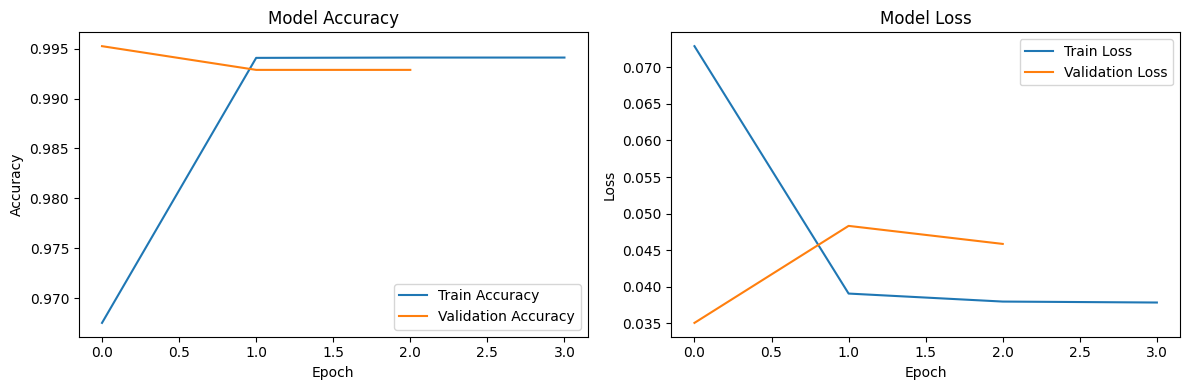

In [69]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Model Training result

The training result shows that the KoBERT binary classification model reached **99.41%** accuracy on the training set and **99.29%** accuracy on the validation set.
<br>
The evaluation metrics show a recall of **98.69%**, a precision of **99.89%**, and an F1 score of **99.28%**.